In [1]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import pickle

In [2]:
# Load the dataset
data_path = "/content/SMSSpamCollection_v1"  # Update the path according to where you upload your file in Colab
df = pd.read_csv(data_path, sep='\t', header=None, names=['Category', 'Message'])

# Encode labels
df['Category'] = df['Category'].map({'ham': 0, 'spam': 1})

# Tokenize the messages
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['Message'])
X = tokenizer.texts_to_sequences(df['Message'])
X = pad_sequences(X, maxlen=100)

# Prepare target variable
y = np.array(df['Category'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [3]:
def load_glove_embeddings(file_path):
    embeddings_index = {}
    with open(file_path, encoding='utf8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    return embeddings_index

glove_path = '/content/glove.6B.100d.txt'  # Update with the correct path
embeddings_index = load_glove_embeddings(glove_path)

# Prepare embedding matrix
embedding_dim = 100
word_index = tokenizer.word_index
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector


In [4]:
import re
df['has_url'] = df['Message'].apply(lambda x: 1 if re.search(r'http[s]?://', x) else 0)
X = np.hstack((X, df['has_url'].values.reshape(-1, 1)))

In [5]:
spam_keywords = ['free', 'win', 'winner', 'urgent', 'claim', 'prize', 'cash']
for keyword in spam_keywords:
    df[f'{keyword}_freq'] = df['Message'].apply(lambda x: x.lower().split().count(keyword))
    X = np.hstack((X, df[f'{keyword}_freq'].values.reshape(-1, 1)))


In [11]:
df_orig = df.copy()
df_orig.sample(5)

,Category,Message,has_url,free_freq,win_freq,winner_freq,urgent_freq,claim_freq,prize_freq,cash_freq
5130,0,Any way where are you and what doing.,0,0,0,0,0,0,0,0
3526,0,I not free today i haf 2 pick my parents up to...,0,1,0,0,0,0,0,0
4565,0,Tell me again what your address is,0,0,0,0,0,0,0,0
1245,0,Now? I'm going out 4 dinner soon..,0,0,0,0,0,0,0,0
5388,0,NOT MUCH NO FIGHTS. IT WAS A GOOD NITE!!,0,0,0,0,0,0,0,0


In [12]:
# Calculate the average number of words per message
avg_words_len = round(sum([len(message.split()) for message in df['Message']]) / len(df['Message']))

print(f"Average number of words per message: {avg_words_len}")

Average number of words per message: 16


In [34]:
# Model parameters
SEQUENCE_LENGTH = 100
EMBEDDING_SIZE = 100
BATCH_SIZE = 64
EPOCHS = 20

# Build the model
model = Sequential([
    Embedding(len(tokenizer.word_index) + 1, EMBEDDING_SIZE, SEQUENCE_LENGTH),
    LSTM(128, return_sequences=True),
    Dropout(0.2),
    LSTM(128),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Build the model to ensure it is configured with the correct input shape
model.build(input_shape=(BATCH_SIZE, SEQUENCE_LENGTH))

# Display model summary
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
Exception ignored in: <function _xla_gc_callback at 0x7cbd25073b50>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/lib/__init__.py", line 98, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)              │ (64, 100, 100)              │         907,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_14 (LSTM)                       │ (64, 100, 128)              │         117,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (64, 100, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_15 (LSTM)                       │ (64, 128)                   │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (64, 128)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (64, 1)                     │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,156,261 (4.41 MB)

 Trainable params: 1,156,261 (4.41 MB)

 Non-trainable params: 0 (0.00 B)

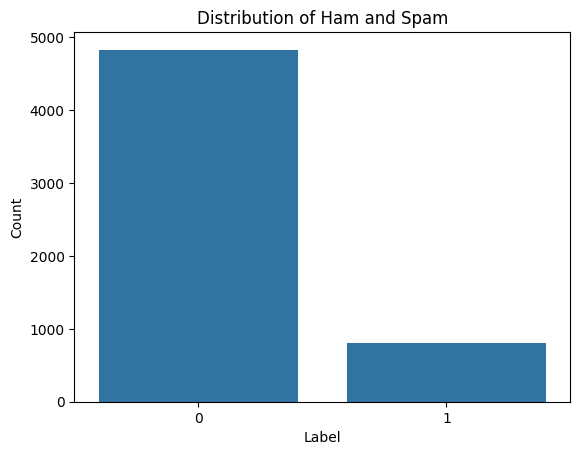

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame and 'label' is the column with Ham/Spam labels
sns.countplot(x=df['Category'])
plt.title('Distribution of Ham and Spam')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

In [36]:
# Train the model
history = model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_split=0.1)

Epoch 1/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 36s 512ms/step - accuracy: 0.8758 - loss: 0.3647 - val_accuracy: 0.9693 - val_loss: 0.1070
Epoch 2/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 42s 540ms/step - accuracy: 0.9849 - loss: 0.0546 - val_accuracy: 0.9740 - val_loss: 0.0887
Epoch 3/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 32s 541ms/step - accuracy: 0.9949 - loss: 0.0164 - val_accuracy: 0.9716 - val_loss: 0.0939
Epoch 4/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 41s 535ms/step - accuracy: 0.9984 - loss: 0.0063 - val_accuracy: 0.9764 - val_loss: 0.0981
Epoch 5/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 32s 540ms/step - accuracy: 0.9998 - loss: 0.0020 - val_accuracy: 0.9787 - val_loss: 0.1028
Epoch 6/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 32s 535ms/step - accuracy: 0.9997 - loss: 0.0027 - val_accuracy: 0.9787 - val_loss: 0.1114
Epoch 7/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 50s 690ms/step - accuracy: 0.9999 - loss: 6.1230e-04 - val_accuracy: 0.9787 - val_loss: 0.1028
Epoch 8/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 33s 545ms/step - accuracy: 0.9998 - loss: 0.0012 - val_

44/44 ━━━━━━━━━━━━━━━━━━━━ 7s 148ms/step
Accuracy: 0.9922
Classification Report:
               precision    recall  f1-score   support

         ham       0.99      1.00      1.00      1205
        spam       0.99      0.96      0.97       203

    accuracy                           0.99      1408
   macro avg       0.99      0.98      0.98      1408
weighted avg       0.99      0.99      0.99      1408



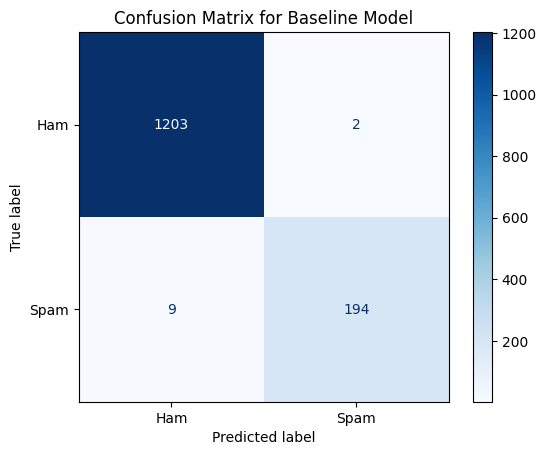

In [37]:
# Evaluate the model
y_pred = (model.predict(X_test) > 0.5).astype("int32")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=['ham', 'spam']))

# Confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Ham', 'Spam'])

disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Baseline Model')
plt.show()

# Save the trained model and tokenizer
model.save("/content/spam_detection_model_4.keras")
with open('/content/tokenizer_4.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

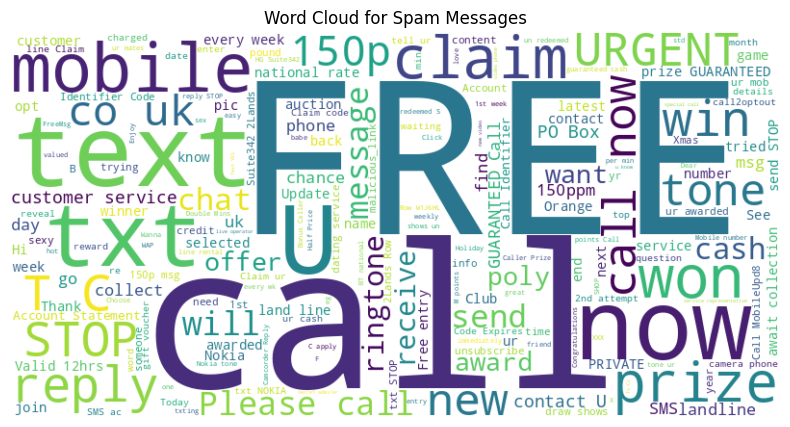

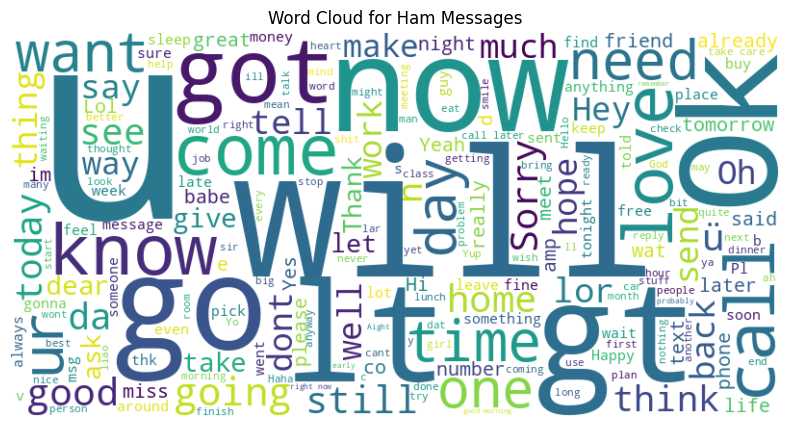

In [38]:
from wordcloud import WordCloud
# Word Cloud for Spam Messages
spam_text = " ".join(message for message in df[df['Category'] == 1]['Message'])
spam_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(spam_text)

plt.figure(figsize=(10, 5))
plt.imshow(spam_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Spam Messages')
plt.show()

# Word Cloud for Ham Messages
ham_text = " ".join(message for message in df[df['Category'] == 0]['Message'])
ham_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(ham_text)

plt.figure(figsize=(10, 5))
plt.imshow(ham_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Ham Messages')
plt.show()